In [2]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import pybedtools as bt
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

path = '/fast/AG_Ohler/frederick/projects/mpra/mrl_te_comparison'


Steps to obtain Transcript IDs for mrl_varlen library from Sample et al (16739 seqs with MRL)

1) Map library fasta as reads to genome with STAR -> Alignments.bam (specifying genomic locations and sample_id)
2) Remove features other than transcripts from the annotation -> genome.transcripts.gtf
3) Intersect Alignments.bam with genome.transcripts.gtf to obtain transcript and gene IDs for genomic locations in the bam file -> tr_id_intersect.bed
4) Process the resulting bed file here, to obtain table with sample_id and tr_id/gene_id -> tr_id_df
5) Merge with MRL dataset to obtain table with smaple_id, tr_id/gene_id and MRL value

## Preprocessing

Preprocessing Human 5'UTR Reporter Data from Sample et al 2019 and Riboseq/RNAseq Data from Andreev et al 2019 to correlate mean ribosome load and translation efficiency in HEK293T cells. This will allow me to assess how similar quantification of translation with polysome profiling is to riboseq. In polysome profiling, ribosomes along the whole transcript are quantified. When calculating translation efficiencies, only reads mapping to CDS are taken into account. Sometimes even only one ORF in the CDS. The big question is: Does this make a difference in an MPRA context? Does it make sense to find a better assay to quantify translation in an MPRA context than polysome profiling?

In [3]:
mrl_varlen = pd.read_csv(path + '/data/GSM4084997_varying_length_25to100.csv')
mrl_varlen = mrl_varlen.loc[:, ['utr','set','total_reads','rl', 'len']]
mrl_varlen = mrl_varlen[mrl_varlen['set']=='human'].reset_index(drop=True)
#same filter as in Sample et al
mrl_varlen = mrl_varlen[mrl_varlen['total_reads']>=10]

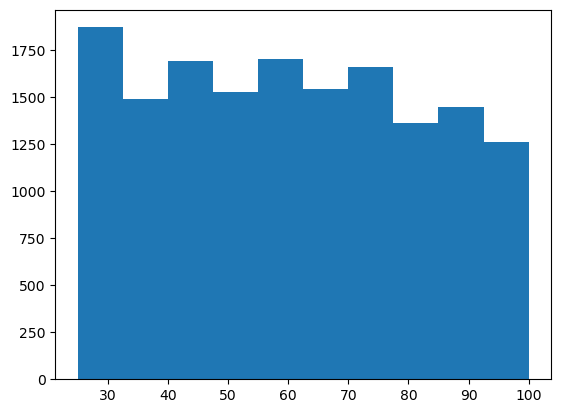

In [4]:
plt.hist(mrl_varlen['len'])
plt.show()

In [5]:
#saving the processed data to a csv file
#mrl_varlen.to_csv(path + '/data/mrl_varlen.csv')

In [6]:
mrl_50 = pd.read_csv(path + '/data/GSM3130443_designed_library.csv', low_memory=False)
mrl_50 = mrl_50.loc[:, ['utr','rl','total','info1','info2','library']]
mrl_50 = mrl_50[mrl_50.library == 'human_utrs'].reset_index(drop=True)
mrl_50.rename(columns = {'info2':'Transcript stable ID'}, inplace = True)
mrl_50.rename(columns = {'info1':'Gene stable ID'}, inplace = True)
#keep 25000 seqs with most reads (as in Sample et al)
mrl_50 = mrl_50.sort_values('total', ascending=False).reset_index(drop=True).iloc[:25000]

In [7]:
#saving the processed data to a csv file
#mrl_50.to_csv(path + '/data/mrl_50.csv')

These csv files are then further processsed with get_tids.sh, which obtains gene and transcript IDs for each sample et al 5UTR sequence.

### Convert csv to fasta for STAR input

In [ ]:
#os.system('bash csv_to_fasta.sh')

### Bed File Processing and Merging

In the following part, the resulting bed file is used to merge two dataframes to obtain one that contains both the gene/transcript IDs and the 5UTR sequence:
- a dataframe containing transcript IDs, gene IDs, genomic location mapping of the 5UTR from Sample et al, sample et al IDs
- a dataframe containing sample et al IDs, 5UTR sequences
This dataframe will later be used to correlate MRL and TE values for sequences with the same gene/transcript ID.

In [7]:
def get_ids(bedfile, tr_id_field=20, sample_id_field=4, mode='one_iso_per_gene'):
    """
    Extracts information about entries in a bedfile and creates a dataframe from it.
    """
    file = bt.BedTool(bedfile)
    data_list = []

    #loop over rows/intervals of bedfile to gather info
    for interval in file:

        #gather info from interval object (row) of the bedtool object 
        chr = interval.chrom
        start = interval.start
        end = interval.end
        sample_id = interval.fields[3]
        gene_id = interval.fields[tr_id_field].split(';')[0]
        tr_id = interval.fields[tr_id_field].split(';')[1]
        info = interval.fields[tr_id_field].split(';')[2:]

        #fetch sequence corresponding to genomic coordinates in bed file
        #location = str(str(chr) + ':' + str(start) + '-' + str(end))
        #seq = bt.bedtool.BedTool.seq(location, genome_fasta)

        #create list of dictionaries containing information about interval
        data_list.append({'chr': chr, 'start': start, 'end': end , 'sample_id': sample_id, 'Gene stable ID version': gene_id.split('"')[1], 'Transcript stable ID version': tr_id.split('"')[1], 'info': info})
        
    
    #create pandas df from list of dictionaries
    data = pd.DataFrame(data_list, columns=['chr', 'start', 'end','sample_id', 'Gene stable ID version', 'Transcript stable ID version', 'info'])
    
    #convert type of sample_id column to int64 for later merging
    data['sample_id'] = data['sample_id'].astype('int64')
    
    return data


def merge_ids(tr_id_data, rl_data):
    """
    Merges two dataframes on the 'sample_id' column and adds for transcript IDs and gene IDs without version specification.
    """
    #assign sample et al 5UTR ID to seq as new column
    rl_data['sample_id'] = rl_data.index

    #merge dataframes based on sample et al 5UTR ID column
    merged_data = pd.merge(rl_data, tr_id_data, on='sample_id', how='inner')

    #remove ID versions in merged dataframe
    merged_data_copy = merged_data.copy()
    
    for i, row in merged_data_copy.iterrows():
        merged_data_copy.at[i, 'Transcript stable ID'] = row['Transcript stable ID version'].split('.')[0]
        merged_data_copy.at[i, 'Gene stable ID'] = row['Gene stable ID version'].split('.')[0]

    return merged_data_copy


def collapse_transcripts(data, val_col='rl', dup_col='Gene stable ID', mode='mean'):
    """
    sums translation values from all transcripts of a gene an returns a dataframe containing only genes
    for correlation on gene-level quantifications of translation
    """
    #keep only MRL value from transcript with highest expression per gene
    if mode=='highest':
        data_sorted = data.sort_values(by=val_col, ascending=False)
        data_filtered = data_sorted.drop_duplicates(subset=[dup_col], keep='first')

    #take average MRL across transcripts of the same gene
    elif mode=='mean':
        data_filtered = data.groupby('Gene stable ID')['rl'].mean().reset_index()

    #sum up MRL values for all transcripts of the same gene
    elif mode=='sum':
        data_filtered = data.groupby('Gene stable ID')['rl'].sum().reset_index()

    return data_filtered
    


In [8]:
#os.system('bash get_tids.sh')

v1: Mapping to hg38(v24)
v2: Mapping to hg38(v44)
v3: Mapping to hg38(v44), but only UTR features

In [9]:
# get df with transcript IDs from bed file
tr_id_df = get_ids(path + '/data/STAR/mrl_varlen/tr_mrl_varlen.bed')
print('Number of transcripts in bed file for v1 (mrl_varlen):', tr_id_df.shape[0])
# merge dataframes on sample et al ID
merged_data = merge_ids(tr_id_df, mrl_varlen)

#Compare v1(old genome+annotation,) to v2(-wa and -wb options in bedtools,)
v2tr_id_df = get_ids(path + '/data/STAR/mrl_varlen/v2tr_mrl_varlen.bed')
v2merged_data = merge_ids(v2tr_id_df, mrl_varlen)
print('Number of transcripts in bed file for v2 (mrl_varlen):', v2tr_id_df.shape[0])
# show head of merged df
#merged_data.head(10)

Number of transcripts in bed file for v1 (mrl_varlen): 167463
Number of transcripts in bed file for v2 (mrl_varlen): 185155


In [10]:
mrl50_tr_id = get_ids(path + '/data/STAR/mrl_50/v2tr_mrl_50.bed')
v2mrl50_merged = merge_ids(mrl50_tr_id, mrl_50)
print('Number of transcripts in bed file for v2 (mrl_50):', mrl50_tr_id.shape[0])
print('Number of transcripts in merged file (mrl_50):', v2mrl50_merged.shape[0])

Number of transcripts in bed file for v2 (mrl_50): 453643
Number of transcripts in merged file (mrl_50): 279339


In [11]:
# save as csv
#merged_data.to_csv(path + '/data/mrl_varlen_merged.csv')
#v2merged_data.to_csv(path + '/data/v2mrl_varlen_merged.csv')

In [28]:
v3tr_id_df = get_ids(path + '/data/STAR/mrl_varlen/v3tr_mrl_varlen.bed')
v3merged_data = merge_ids(v3tr_id_df, mrl_varlen)
print('Number of transcripts in bed file for v3 (mrl_varlen):', v3merged_data.shape[0])

v3mrl50_tr_id = get_ids(path + '/data/STAR/mrl_varlen/v3tr_mrl_varlen.bed')
v3mrl50_merged = merge_ids(v3mrl50_tr_id, mrl_50)
print('Number of transcripts in bed file for v3 (mrl_50):', v3mrl50_merged.shape[0])

Number of transcripts in bed file for v3 (mrl_varlen): 33504
Number of transcripts in bed file for v3 (mrl_50): 35761


In [25]:
v3merged_data['sample_id'].unique().size


9255

In [26]:
v3mrl50_merged['sample_id'].unique().size

9948

In [62]:
#v3merged_data = v3merged_data[(v3merged_data['len'] >= 40) & (v3merged_data['len'] <= 60)]
#only few reporters are left when I do this and the correlation dos not increase either

There are 5996 entries left in the mrl_varlen library and 6302 entries left in the mrl_50 library.
After merging there are 5996 entries left.
There are 120 overlapping entries left.


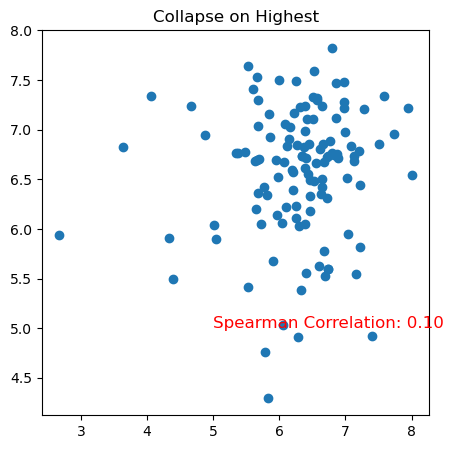

In [21]:
varlen_collapsed = collapse_transcripts(v3merged_data, mode='highest')
fifty_collapsed = collapse_transcripts(v3mrl50_merged, mode='highest')
print('There are '+str(len(varlen_collapsed))+' entries left in the mrl_varlen library and '+str(len(fifty_collapsed))+' entries left in the mrl_50 library.')

#merge on gene ID
mrl_merged = pd.merge(varlen_collapsed, fifty_collapsed, on='Gene stable ID', how='inner')
print('After merging there are '+str(len(mrl_merged))+' entries left.')

#keep only overlapping UTRs
mrl_merged = mrl_merged[(mrl_merged['start_y']<mrl_merged['end_x'])&(mrl_merged['end_y']<mrl_merged['start_x'])]
print('There are '+str(len(mrl_merged))+' overlapping entries left.')

#plot
fig, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize = (5,5))
                               
ax1.scatter(mrl_merged['rl_x'], mrl_merged['rl_y'])
correlation_ax1, _ = sp.stats.spearmanr(mrl_merged['rl_x'], mrl_merged['rl_y'])
ax1.text(5, 5, f"Spearman Correlation: {correlation_ax1:.2f}", fontsize=12, color='red')
ax1.set_title('Collapse on Highest')

plt.show()

#### What do reporters that correlate well/not well have in common?

There are 5996 entries left in the mrl_varlen library and 6302 entries left in the mrl_50 library.
After merging there are 5996 entries left.
After exclusion of uncorrelated reporters, there are 3228 entries left.
After inclusion of uncorrelated reporters, there are 3228 entries left.


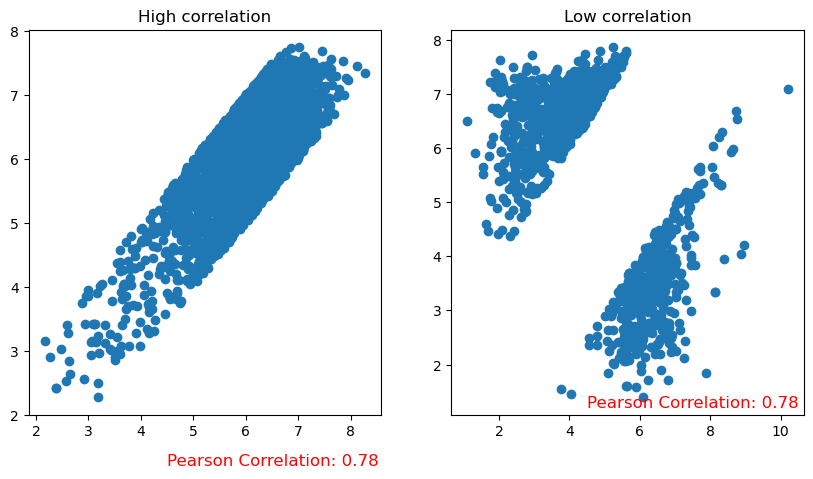

In [55]:
varlen_ = collapse_transcripts(v3merged_data, mode='highest')
fifty_ = collapse_transcripts(v3mrl50_merged, mode='highest')
print('There are '+str(len(varlen_))+' entries left in the mrl_varlen library and '+str(len(fifty_))+' entries left in the mrl_50 library.')

#merge on gene ID
mrl_merged = pd.merge(varlen_, fifty_, on='Gene stable ID', how='inner')
print('After merging there are '+str(len(mrl_merged))+' entries left.')

#keeping only highly correlated reporters
mrl_merged_ex = mrl_merged[abs(mrl_merged['rl_x']-mrl_merged['rl_y'])<1]
print('After exclusion of uncorrelated reporters, there are '+str(len(mrl_merged_ex))+' entries left.')

mrl_merged_in = mrl_merged[abs(mrl_merged['rl_x']-mrl_merged['rl_y'])>2]
print('After inclusion of uncorrelated reporters, there are '+str(len(mrl_merged_ex))+' entries left.')

#keep only overlapping UTRs
#mrl_merged = mrl_merged[(mrl_merged['start_y']<mrl_merged['end_x'])&(mrl_merged['end_y']<mrl_merged['start_x'])]
#print('There are '+str(len(mrl_merged))+' overlapping entries left.')

#plot
fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
                               
ax1.scatter(mrl_merged_ex['rl_x'], mrl_merged_ex['rl_y'])
correlation_ax1, _ = sp.stats.pearsonr(mrl_merged_ex['rl_x'], mrl_merged_ex['rl_y'])
ax1.text(4.5, 1.2, f"Pearson Correlation: {correlation_ax1:.2f}", fontsize=12, color='red')
ax1.set_title('High correlation')

ax2.scatter(mrl_merged_in['rl_x'], mrl_merged_in['rl_y'])
correlation_ax2, _ = sp.stats.pearsonr(mrl_merged_in['rl_x'], mrl_merged_in['rl_y'])
ax2.text(4.5, 1.2, f"Pearson Correlation: {correlation_ax1:.2f}", fontsize=12, color='red')
ax2.set_title('Low correlation')
plt.show()

In [54]:
high_cor = mrl_merged_ex[['utr_x','rl_x','sample_id_x','start_x','end_x','len','Gene stable ID','utr_y','rl_y','sample_id_y','start_y', 'end_y' ]]
#high_cor.to_csv(path+'/data/high_cor.csv')
#72% share same genomic location
low_cor = mrl_merged_in[['utr_x','rl_x','sample_id_x','start_x','end_x','len','Gene stable ID','utr_y','rl_y','sample_id_y','start_y', 'end_y' ]]
#low_cor.to_csv(path+'/data/low_cor.csv')
#91% share same genomic location

In [53]:
low_cor

,utr_x,rl_x,sample_id_x,start_x,end_x,len,Gene stable ID,utr_y,rl_y,sample_id_y,start_y,end_y
0,CGGGGGCCAGAGCAGGCCTGGTGGTGAGCAGGGACGGTGCACCGGACGGCGGGATCGAGCAA,10.195283,5458,15999594,15999688,62,ENSG00000214941,CAGCTAACATTGCTTGAGGATCTAGGCGATTAATTCTTTAGACTGTCATC,7.082374,15231,15999594,15999650
1,TTAGCCGCGGTGCAGACTGCGGCGGCGGTGGTCTGAGGAAGTTCTATCTTGGCGCTAAAGCGGAGACGCATCCCCCGACCCGAGGCTACG,8.954721,3285,43771208,43771246,90,ENSG00000112715,GAGCTGTCAAATCTCCACATCTTCAGCATTAAATATCATGCAACCAAATG,4.207163,3285,43771208,43771246
2,GCTCTGTGTCCCCTGCTAGCCGTAGGTCGTGTGACCCGCAGGCACCGGGAGATCCAGAAGTGAAACGCCAGGCTCTCTGGAGGCCAGGAG,8.883805,7514,40994097,40994133,90,ENSG00000212899,CGGCAGCCTGGGGATATAGCCTCTCCTTCCGATGAAAAGAGAAAGGAAGA,4.040610,7514,40994097,40994133
4,CCTCGGGTTGTGGTTGGTGTGCGGGTTTCGGTTGGAGGACTCGTTGGGGAGGTGGCCTGCGCTTGTAGAGACTGCATCCCCGAGACG,8.761867,5649,134176854,134176950,87,ENSG00000113558,AAGTTCCGGCCCGCGCTGGACTTCTGGGATTCCCTCTTCCCGCCGACACC,6.541895,6923,134176854,134176920
5,TCTAGCTCTCAGTCTGCGCGAGGGTGTAGGAAGGAAAGCCCAGGACCTCCGGAGCAGAGCACAGCAGCTGCAGAGGCAAGGCCAGC,8.733366,7800,169479479,169479553,86,ENSG00000251569,CAGTCCAGGCAAGCTACTGGCACCTGCTGCTCTCAACTAACCTCCACACA,6.688794,6455,169479482,169479553
...,...,...,...,...,...,...,...,...,...,...,...,...
5991,TCTAGCGAAATATGGCTACAGAGAGCCCTGCTACGCGTCGGGTCCAGGTTACTGAAGCTAAAGGAG,1.615264,2304,92764744,92764812,66,ENSG00000185963,GCAAGTTGCTCTTCATCTTTCTCCTTGGTCATGACATTGACTTTGGACAC,4.593148,2304,92764744,92764812
5992,AATGTCTCTTGACAGCGGCGGCGGCGCAGCCGGTTCCGGGTTCGGCGCGGGGCGGGGATGTGAATCCCG,1.557695,58,397191,397222,69,ENSG00000103202,GCGCTCCCCGCTCCCGCCGCCCGCTTCGAGGGTTCTCTCCCCTTGCCACC,5.526933,58,397191,397222
5993,ACTTTTATAAGCCAGCCCCAGGCATCCCAGAGCAAGATGTAGCTGTGTAGTCTCCTTCCATAGCTGCTCTAAGGGGGCTGGCAAC,1.534422,1550,53299749,53299809,85,ENSG00000139637,CGCCGCCGCGATCCCTCCCCGCGCCCGCCGAGCACATCGCCGCCGCCGAG,5.646283,1550,53299749,53299809
5994,AAATGTAGTCACTGTCCCGGAACCTGGGGCAGCGGAGTCCCGTGCGCCCTGTGGTGACAGCTCAGGAGGGTGTGTGCGCTCAGCAGGGGCCAGC,1.322791,15284,66288985,66289037,94,ENSG00000174851,GGCCAGTCCTGAGCAGGCCCAACTCCAGTGCAGCTGCCCACCCTGCCGCC,5.906890,15284,66288985,66289037


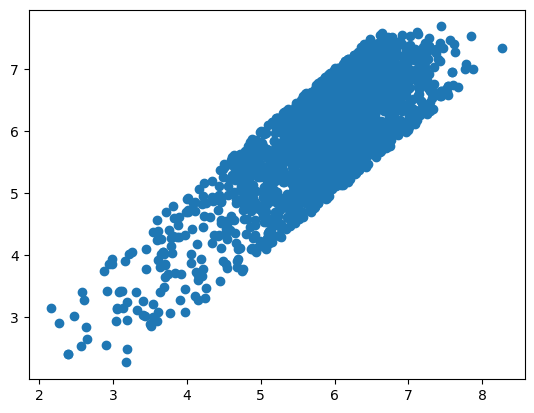

In [41]:
high_cor_same_loc = high_cor[(high_cor['start_x']==high_cor['start_y'])&(high_cor['end_x']==high_cor['end_y'])]
plt.scatter(high_cor_same_loc['rl_x'], high_cor_same_loc['rl_y'])

There are 5996 entries left in the mrl_varlen library and 6302 entries left in the mrl_50 library.
After merging there are 5996 entries left.
After exclusion of uncorrelated reporters, there are 3228 entries left.
There are 4668 entries with the same genomic location.


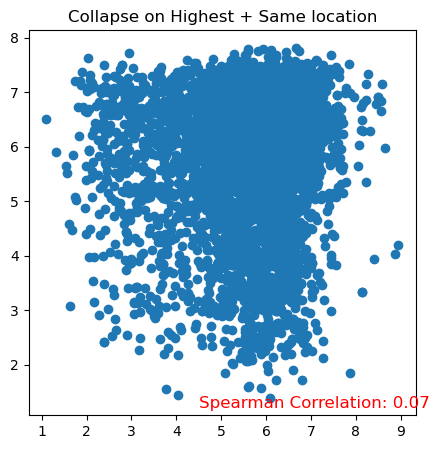

In [42]:
varlen_ = collapse_transcripts(v3merged_data, mode='highest')
fifty_ = collapse_transcripts(v3mrl50_merged, mode='highest')
print('There are '+str(len(varlen_))+' entries left in the mrl_varlen library and '+str(len(fifty_))+' entries left in the mrl_50 library.')

#merge on gene ID
mrl_merged = pd.merge(varlen_, fifty_, on='Gene stable ID', how='inner')
print('After merging there are '+str(len(mrl_merged))+' entries left.')

#keeping only highly correlated reporters
#mrl_merged_ex = mrl_merged[abs(mrl_merged['rl_x']-mrl_merged['rl_y'])<1]
print('After exclusion of uncorrelated reporters, there are '+str(len(mrl_merged_ex))+' entries left.')

#keep only reporters with same location
same_loc = mrl_merged[(mrl_merged['start_x']==mrl_merged['start_y'])&(mrl_merged['end_x']==mrl_merged['end_y'])]
print('There are '+str(len(same_loc))+' entries with the same genomic location.')

#plot
fig, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize = (5,5))
                               
ax1.scatter(same_loc['rl_x'], same_loc['rl_y'])
correlation_ax1, _ = sp.stats.spearmanr(same_loc['rl_x'], same_loc['rl_y'])
ax1.text(4.5, 1.2, f"Spearman Correlation: {correlation_ax1:.2f}", fontsize=12, color='red')
ax1.set_title('Collapse on Highest + Same location')

plt.show()


#Is it the location of the gene or of the UTR?

In [49]:
pd.set_option('display.max_colwidth', 150)
high_cor[['utr_x', 'utr_y']]

,utr_x,utr_y
22,GTGGGCGTCTTGCTGCCTTGGGTAGGGGGTTAAAATCGTTCTTGAGAGGAACGTCTCTGTGCGAAGAGATA,AATAGAATCAGTCTCATTTGTAGGCACTGTAGACCATCTCCATTCCCTAC
36,AGTCACACAGCTGCCTGGTAGGTGACTGGAGGCCTTGATCGGTTCTCATTGAGATTTTGCTGCTGTGACCCCAACCCTGCCTCCCTCCCCACCCTGCG,CCACTGTTTGCCAAGTACTGTTGTTACAGTTCTTATCCGCGTGAATACAC
46,GGTCTGTGCAGGTTCGCGGGTCGCTGGCGGGGGTCGTGAGGGAGTGCGCCGGGAGCGGAGAT,GTCCTTGCACCTAAGGAACCTCTGCTGCCAGCCCTTCCTCACTTTTGGAA
49,GTGATTACCACTCCAGCTGCTGGGAACGGGCGAGAAAGAGGAGGAGGCGAGAAACTCCCACCGACCCACAGAGGGAGC,TTGTGTCTTGAGAAGACAGGCATTTTAGAGGTATTACAAGTGGATAAATA
51,ATTCTGCGCCTGCGCGCGGCTACAGCACGGTTCGTTTTTCCTTTAGTCAGGAAGGACGTTGGTGTTGAGGTTAGCATACGTATCAAGGACAGTAACTACC,GTTGAAAAGCTTATTAGCTGCTGTACGGTAAAACTCCTTCTTTCTGCAAC
...,...,...
5887,GCCCCTGGGTGCGCGCGGCGGTGGTGGCGGCGGCCGAGCCTCGCTTTGAGAGACAGAATGGACAGCAAATT,GGACCTGTCTGAATGTAGGCTGCAGCAGTCCTGAAGGTTGATGGAGGGCC
5919,CGCTGGGGAAGCTGAAGCAGTTCGATGCCTACCCCAAGACTTTGGAGGACTTCCGGGTCAAGACCTGCGGGGGCGCCACCGTGACCA,GATGGCGTGCTTGTTGGAGACCCCAATCCGCATGAGCGTCCTTTCGAGAC
5920,CGCTGGGGAAGCTGAAGCAGTTCGATGCCTACCCCAAGACTTTGGAGGACTTCCGGGTCAAGACCTGCGGGGGCGCCACCGTGACCA,GATGGCGTGCTTGTTGGAGACCCCAATCCGCATGAGCGTCCTTTCGAGAC
5942,GCCTGGGGCCGGGTCGTCATGGCGACGCGCCACGCTAACGCATGGTGTCGGAGGGAGGCCCACTTGCTGAACAGCAGGGAGCG,AGCTGAGAGGTCTGACAAGATGTACCAGGTCCCACTACCACTGGATCGGG


What is the proportion of sequence similarity in high and low correlated fractions between library pairs?

In [61]:
def calculate_similarity(seq1, seq2):
    """
    Calculate the similarity between two sequences as a percentage.
    The similarity is calculated as (1 - Hamming distance / length of sequence) * 100.
    """
    if len(seq1) != len(seq2):
        return None  # Return None if sequences are of unequal length

    hamming_distance = sum(c1 != c2 for c1, c2 in zip(seq1, seq2))
    similarity = (1 - hamming_distance / len(seq1)) * 100
    return similarity

# Calculate similarity for each pair in high_cor and low_cor datasets
high_cor['similarity'] = high_cor.apply(lambda row: calculate_similarity(row['utr_x'], row['utr_y']), axis=1)
low_cor['similarity'] = low_cor.apply(lambda row: calculate_similarity(row['utr_x'], row['utr_y']), axis=1)

# Calculate the average similarity for each dataset
avg_similarity_high_cor = high_cor['similarity'].mean()
avg_similarity_low_cor = low_cor['similarity'].mean()

print(avg_similarity_high_cor, avg_similarity_low_cor)

# Calculate the fraction of sequences with unequal length in high_cor dataset
high_cor_unequal_lengths = high_cor[high_cor['len'] != 50]
fraction_high_cor_unequal = len(high_cor_unequal_lengths) / len(high_cor)

# Calculate the fraction of sequences with unequal length in low_cor dataset
low_cor_unequal_lengths = low_cor[low_cor['len'] != 50]
fraction_low_cor_unequal = len(low_cor_unequal_lengths) / len(low_cor)

print(fraction_high_cor_unequal, fraction_low_cor_unequal)

27.58974358974359 28.181818181818183
0.9879182156133829 0.9901785714285715


### Investigating Different Ways to Collapse Transcripts

#### Collapse via Mean, Highest or Sum

1) Collapsing transcripts gene-wise
2) Merging collapsed dataframes via gene ID
3) include only overlapping pairs of reporters

There are 5996 entries left in the mrl_varlen library and 6302 entries left in the mrl_50 library.
After merging there are 5996 entries left.
There are 5996 entries left in the mrl_varlen library and 6302 entries left in the mrl_50 library.
After merging there are 5996 entries left.
There are 5996 entries left in the mrl_varlen library and 6302 entries left in the mrl_50 library.
After merging there are 5996 entries left.


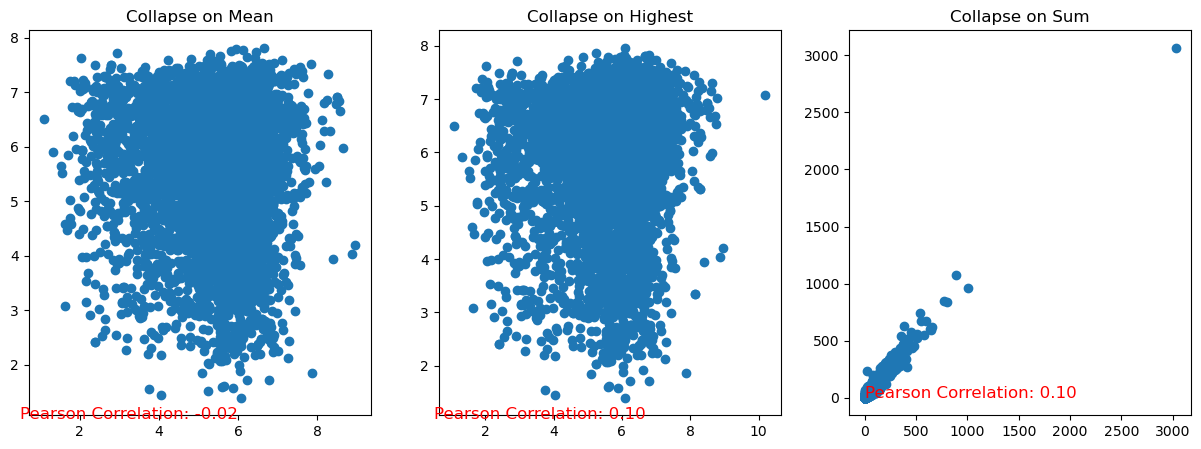

In [82]:
modes = ['mean', 'highest', 'sum']
df_list = []
for i in modes:
    #mrl_merged = pd.merge(v3merged_data, v3mrl50_merged, on='Gene stable ID', how='inner')
    #print('After merging there are: '+str(len(mrl_merged)))
    #mrl_merged_collapsed = collapse_transcripts(mrl_merged, mode=i)
    #print('After collapsing there are: '+str(len(mrl_merged_collapsed)))
    
    #keep only one entry with the highest translation value per gene
    varlen_collapsed = collapse_transcripts(v3merged_data, mode=i)
    fifty_collapsed = collapse_transcripts(v3mrl50_merged, mode=i)
    print('There are '+str(len(varlen_collapsed))+' entries left in the mrl_varlen library and '+str(len(fifty_collapsed))+' entries left in the mrl_50 library.')

    #merge on gene ID
    mrl_merged = pd.merge(varlen_collapsed, fifty_collapsed, on='Gene stable ID', how='inner')
    print('After merging there are '+str(len(mrl_merged))+' entries left.')

    #exclude MRL values higher than 4000
    #mrl_merged = mrl_merged[(mrl_merged['rl_x']<2000)&(mrl_merged['rl_y']<2000)]

    #keep only overlapping UTRs
    #mrl_merged = mrl_merged[(mrl_merged['start_y']<mrl_merged['end_x'])&(mrl_merged['end_y']<mrl_merged['start_x'])]
    #print('There are '+str(len(mrl_merged))+' overlapping entries left.')
    
    #create list of dfs
    df_list.append(mrl_merged)

    

#sanity check: correlate the two MRL libraries for both modes:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (15,5))
                               
ax1.scatter(df_list[0]['rl_x'], df_list[0]['rl_y'])
correlation_ax1, _ = sp.stats.pearsonr(df_list[0]['rl_x'], df_list[0]['rl_y'])
ax1.text(0.5, 1.0, f"Pearson Correlation: {correlation_ax1:.2f}", fontsize=12, color='red')
ax1.set_title('Collapse on Mean')

ax2.scatter(df_list[1]['rl_x'], df_list[1]['rl_y'])
correlation_ax2, _ = sp.stats.pearsonr(df_list[1]['rl_x'], df_list[1]['rl_y'])
ax2.text(0.5, 1.0, f"Pearson Correlation: {correlation_ax2:.2f}", fontsize=12, color='red')
ax2.set_title('Collapse on Highest')

#totally arbitrary since sum is based on number of transcript isoforms included in the screen
ax3.scatter(df_list[2]['rl_x'], df_list[2]['rl_y'])
correlation_ax3, _ = sp.stats.pearsonr(df_list[2]['rl_x'], df_list[2]['rl_y'])
ax3.text(0.5, 1.0, f"Pearson Correlation: {correlation_ax2:.2f}", fontsize=12, color='red')
ax3.set_title('Collapse on Sum')

plt.show()

#WHY DO THEY NOT CORRELATE?
#probably matching of UTRs that are not from the same position in the gene.

### Calculating Translation Efficiencies

Calviello &  Landthaler (https://www.nature.com/articles/nmeth.3688#Sec9)
ribo-seq https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1887643
rna-seq https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1306496

Pavel Baranov
ribo-seq & rna-seq 


In [68]:
rpf = pd.read_csv(path + '/data/riboseq/GSM1331342_A1_control_rpf_rep_1.csv', sep='\t', low_memory=False)
rpf = rpf[rpf['raw mapped reads, CDS'] > 10 & rpf['RefSeq accession identifier'].str.startswith('N',0)]

rna = pd.read_csv(path + '/data/riboseq/GSM1331343_A3_control_rna_rep_1.csv', sep='\t', low_memory=False)
rna = rna[rna['raw mapped reads, CDS'] > 10 & rna['RefSeq accession identifier'].str.startswith('N',0)]

In [69]:
#lets correlate rpf and rna raw reads in the CDS as quality control. They should correlate pretty well.
#merge dfs on RefSeq accession identifier, keep raw mapped reads in CDS
baranov = pd.merge(rpf, rna, on='RefSeq accession identifier', how='inner')

#correlate the two columns containing rpf and rna raw reads mapping to CDS
pr, _ = sp.stats.pearsonr(baranov['raw mapped reads, CDS_x'], baranov['raw mapped reads, CDS_y'])
print('Pearson correlation between Riboseq and RNAseq signal of transcripts is:', pr)

#export refseq IDs to retrieve translation table from Biomart
#these IDs are obtained from Baranov data and therefore do not include many of the transcripts in the polysome profiling data
#riboseq_merged['RefSeq accession identifier'].to_csv(path + '/data/refseq_ids.csv', index=False)

#import translation table
tl = pd.read_csv(path + '/data/id_translation_biomart.txt', sep='\t')
tl.rename(columns= {'RefSeq mRNA ID': 'RefSeq accession identifier'}, inplace = True)

#translate baranov data
baranov_tl = pd.merge(baranov, tl, on='RefSeq accession identifier', how='inner')

#collapse transcripts
baranov_collapsed = baranov_tl.groupby('Gene stable ID').agg({'raw mapped reads, CDS_x':'sum', 'raw mapped reads, CDS_y':'sum'}).reset_index()


#add TE as ratio between raw number of reads mapping to coding sequence for rpf and rna, as column
baranov_collapsed['TE'] = baranov_collapsed['raw mapped reads, CDS_x']/baranov_collapsed['raw mapped reads, CDS_y']

#lets do a log2 transformation of TEs and center around mean
baranov_collapsed['log2TE'] = np.log2(baranov_collapsed['TE']) - np.mean(np.log2(baranov_collapsed['TE']))

Pearson correlation between Riboseq and RNAseq signal of transcripts is: 0.8411124861085553


In [70]:
baranov_collapsed

,Gene stable ID,"raw mapped reads, CDS_x","raw mapped reads, CDS_y",TE,log2TE
0,ENSG00000000003,243.0,266.0,0.913534,0.888777
1,ENSG00000000419,332.0,310.0,1.070968,1.118162
2,ENSG00000000457,43.0,80.0,0.537500,0.123583
3,ENSG00000001036,195.0,508.0,0.383858,-0.362108
4,ENSG00000001084,195.0,434.0,0.449309,-0.134974
...,...,...,...,...,...
11921,ENSG00000292344,38.0,251.0,0.151394,-1.704369
11922,ENSG00000292345,30.0,177.0,0.169492,-1.541468
11923,ENSG00000292348,182.0,700.0,0.260000,-0.924170
11924,ENSG00000292358,152.0,340.0,0.447059,-0.142217


Text(0.5, 1.0, 'Log2(TE) - Mean')

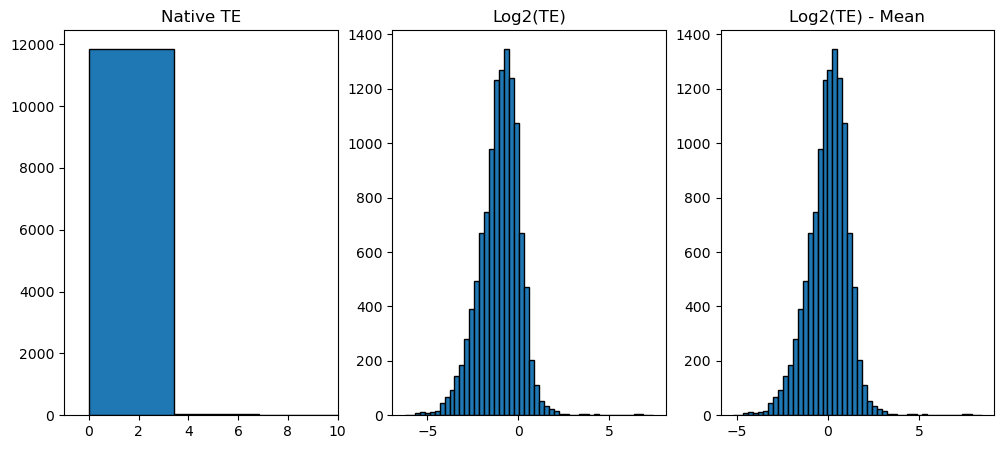

In [71]:
#plot TE histogram for native,log2 transform, and mean-centered log2 transform
fig, (ax0,ax1,ax2) = plt.subplots(nrows = 1, ncols = 3, figsize = (12,5))
n_bins = 50

ax0.hist(baranov_collapsed['TE'], n_bins, edgecolor='black')
ax0.set_title('Native TE')
ax0.set_xlim(-1,10)

ax1.hist(np.log2(baranov_collapsed['TE']), n_bins, edgecolor='black')
ax1.set_title('Log2(TE)')

ax2.hist(np.log2(baranov_collapsed['TE'])- np.mean(np.log2(baranov_collapsed['TE'])), n_bins, edgecolor='black')
ax2.set_title('Log2(TE) - Mean')


# Correlate MRL x TE for all Conditions

- Why are there only 2500 data points shared between all dataframes?
- Why do mrl_50 and mrl_varlen not correlate? -> mapping may be broken, gene ids vs transcript ids

In [78]:
#make dict with all conditions
conditions = [mrl_50, df_list[0], baranov_collapsed]
#include later: 'te_calviello': calviello

#TO-DO
#extend to more than two dataframes
#calculate TEs for calviello data

#correlate all conditions with themselves and each other to make confusion matrix
def correlation_matrix(conditions, columns_to_keep=['rl', 'log2TE'], method='pearson'):
    """
    Creates a correlation matrix, correlating the specified columns from a number of dataframes.

    """
    

    #merge all into one df containing IDs and columns to be correlated
    merged_df = conditions[0]
    for i in range(1, len(conditions)):
        merged_df = pd.merge(merged_df, conditions[i], on='Gene stable ID')

    #keep only relevant columns
    merged_df = merged_df[columns_to_keep]
    
    #create pairwise correlations with pandas.corr()
    cor_df = merged_df.corr(method=method).round(3)

    #plot the resulting correlation matrices separately with sns.heatmap()
    fg, ax = plt.subplots(figsize=(8,6))
    
    ax = sns.heatmap(cor_df, cmap='coolwarm')

    #create annotations
    #for x in range(len(conditions))


    plt.show()


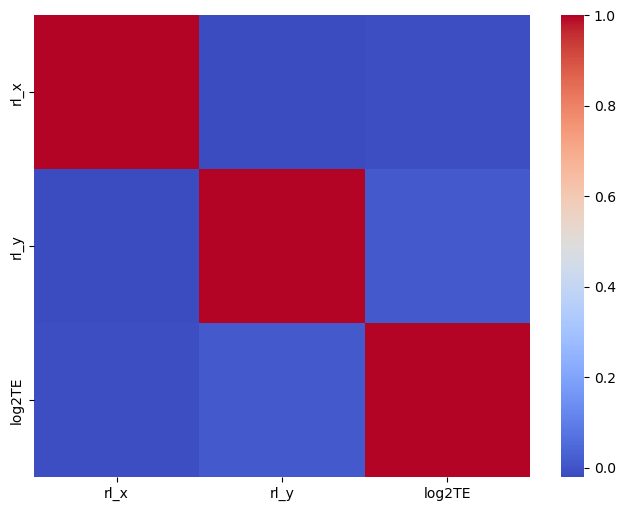

In [79]:
correlation_matrix(conditions,  columns_to_keep=['rl_x', 'rl_y', 'log2TE'], method='spearman')

In [60]:
conditions = [mrl_50, df_list[0], baranov_te]
merged_df = conditions[0]
for i in range(1, len(conditions)):
    merged_df = pd.merge(merged_df, conditions[i], on='Gene stable ID')

#collapse transcripts

#keep only relevant columns
merged_df = merged_df[['rl_x','rl_y', 'log2TE']]
    
#create pairwise correlations with pandas.corr()
#cor_df = merged_df.corr().round(3)

    #plot the resulting correlation matrices separately with sns.heatmap()
    #fg, ax = plt.subplots(figsize=(10,8))
    
    #ax = sns.heatmap(cor_df, cmap='coolwarm')

    #create annotations
    #for x in range(len(conditions))


    #plt.show()

In [61]:
merged_df

,rl_x,rl_y,log2TE
0,3.481386,5.505161,-0.074962
1,3.481386,5.505161,-0.062736
2,3.481386,5.505161,-0.062736
3,3.481386,5.505161,-0.068862
4,3.481386,5.505161,-0.062736
...,...,...,...
13108,6.408785,5.751686,-1.263034
13109,6.408785,5.751686,-1.263034
13110,6.408785,5.751686,-1.459432
13111,6.408785,5.751686,-1.716207


In [32]:
merged_df['Gene stable ID'].unique().size

NameError: name 'merged_df' is not defined

In [ ]:
#plt.scatter(np.log2(cor_te_mrl_50['TE']), cor_te_mrl_50['rl'])
#print('Pearson correlation between MRL and TE:', sp.stats.pearsonr(np.log2(cor_te_mrl_50['TE']), cor_te_mrl_50['rl']))

### Overview over Dataframe Sizes

- I am loosing 50% of mrl_50 since they do not have a specified transcript ID. I could also obtain transcript IDs similar to mrl_varlen and see if I can retain more sequences.

In [ ]:
print(v2merged_data['Transcript stable ID version'].unique().size)
print(v2merged_data['Gene stable ID version'].unique().size)

In [ ]:
print(mrl_varlen_final['Transcript stable ID'].unique().size)
print(mrl_varlen_final['Gene stable ID'].unique().size)

In [ ]:
print(baranov_te['Transcript stable ID'].unique().size)
print(baranov_te['Gene stable ID'].unique().size)

In [ ]:
print(mrl_50['Transcript stable ID'].unique().size)
print(mrl_50.dropna(subset='Transcript stable ID')['Transcript stable ID'].unique().size)

In [ ]:
mrl_varlen_un = mrl_varlen_final.drop_duplicates(subset='Gene stable ID')
mrl = mrl_50.merge(mrl_varlen_un, on='Transcript stable ID', how='inner')
print('Pearson correlation between MRL datasets:', sp.stats.pearsonr(mrl['rl_x'], mrl['rl_y']))
#5UTRs from both datasets could also originate from different places along the transcript or gene

In [ ]:
mrl